importação das bibliotecas

In [187]:
# Importação das bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

Carregar o conjunto de dados

In [188]:
# Caminho para o dataset (ajuste conforme necessário)
dataset_path = r"C:\Users\eneid\Downloads\Edge_IIoTset_dataset"

# Listar todos os arquivos e subpastas
for root, dirs, files in os.walk(dataset_path):
    print(f"Diretório: {root}")
    for file in files:
        print(f"  Arquivo: {file}")

Diretório: C:\Users\eneid\Downloads\Edge_IIoTset_dataset
Diretório: C:\Users\eneid\Downloads\Edge_IIoTset_dataset\Attack traffic
  Arquivo: Backdoor_attack.csv
  Arquivo: Backdoor_attack.pcap
  Arquivo: DDoS HTTP Flood Attacks.pcap
  Arquivo: DDoS ICMP Flood Attacks.pcap
  Arquivo: DDoS TCP SYN Flood Attacks.pcap
  Arquivo: DDoS UDP Flood Attacks.pcap
  Arquivo: DDoS_HTTP_Flood_attack.csv
  Arquivo: DDoS_ICMP_Flood_attack.csv
  Arquivo: DDoS_TCP_SYN_Flood_attack.csv
  Arquivo: DDoS_UDP_Flood_attack.csv
  Arquivo: MITM (ARP spoofing + DNS) Attack.pcap
  Arquivo: MITM_attack.csv
  Arquivo: OS Fingerprinting attack.pcap
  Arquivo: OS_Fingerprinting_attack.csv
  Arquivo: Password attacks.pcap
  Arquivo: Password_attack.csv
  Arquivo: Port Scanning attack.pcap
  Arquivo: Port_Scanning_attack.csv
  Arquivo: Ransomware attack.pcap
  Arquivo: Ransomware_attack.csv
  Arquivo: SQL injection attack.pcap
  Arquivo: SQL_injection_attack.csv
  Arquivo: Uploading attack.pcap
  Arquivo: Uploading_atta

In [189]:
# Carregar o dataset
csv_path = r"C:\Users\eneid\Downloads\Edge_IIoTset_dataset\Selected dataset for ML and DL\ML-EdgeIIoT-dataset.csv"
df = pd.read_csv(csv_path, low_memory=False)
print("Informações gerais:")
print(df.info())

# Explorar a distribuição de classes
print("\nDistribuição de Attack_label:")
print(df['Attack_label'].value_counts())

print("\nDistribuição por Attack_type:")
print(df['Attack_type'].value_counts())


Informações gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157800 entries, 0 to 157799
Data columns (total 63 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   frame.time                 157800 non-null  object 
 1   ip.src_host                157800 non-null  object 
 2   ip.dst_host                157800 non-null  object 
 3   arp.dst.proto_ipv4         157800 non-null  object 
 4   arp.opcode                 157800 non-null  float64
 5   arp.hw.size                157800 non-null  float64
 6   arp.src.proto_ipv4         157800 non-null  object 
 7   icmp.checksum              157800 non-null  float64
 8   icmp.seq_le                157800 non-null  float64
 9   icmp.transmit_timestamp    157800 non-null  float64
 10  icmp.unused                157800 non-null  float64
 11  http.file_data             157800 non-null  object 
 12  http.content_length        157800 non-null  float64
 13  http.requ

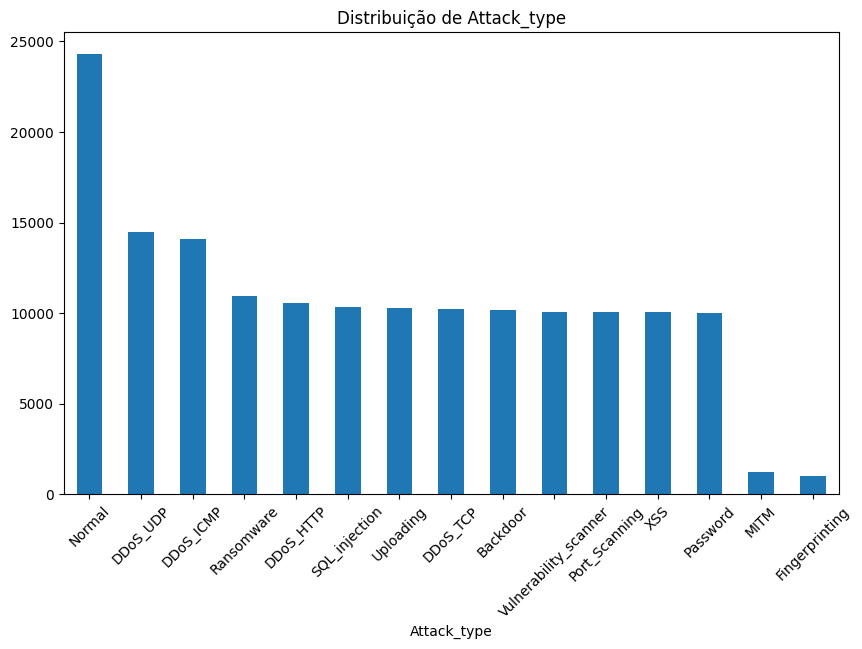

In [190]:
# Visualizações iniciais
plt.figure(figsize=(10, 6))
df['Attack_type'].value_counts().plot(kind='bar', title='Distribuição de Attack_type')
plt.xticks(rotation=45)
plt.show()



In [191]:
# Filtrar para MITM e Normal
df_mitm = df[df['Attack_type'].isin(['Normal', 'MITM'])].copy()

# Mapear para binário (0: Normal, 1: MITM)
df_mitm['Binary_label'] = df_mitm['Attack_type'].map({'Normal': 0, 'MITM': 1})

# Verificar novamente a distribuição
print("\nDistribuição pós-filtragem (Binary_label):")
print(df_mitm['Binary_label'].value_counts())



Distribuição pós-filtragem (Binary_label):
Binary_label
0    24301
1     1214
Name: count, dtype: int64


In [192]:

# Separar features e rótulos
X = df_mitm.drop(columns=['Attack_label', 'Attack_type', 'Binary_label'])
y = df_mitm['Binary_label']

# Verificar tipos de dados
print("\nTipos de dados no dataset:")
print(X.dtypes)

# Identificar colunas não numéricas
non_numeric_cols = X.select_dtypes(exclude=['number']).columns
print("\nColunas não numéricas:")
print(non_numeric_cols)

# Remover colunas irrelevantes ou transformar colunas problemáticas
if 'frame.time' in X.columns:  # Exemplo de transformação para colunas de data/hora
    X['frame.time'] = pd.to_datetime(X['frame.time'], errors='coerce').astype('int64') // 1e9  # Em segundos

# Remover quaisquer colunas restantes que não sejam numéricas
X = X.drop(columns=non_numeric_cols, errors='ignore')

# Confirmar se todas as colunas são numéricas
print("\nConfirmação de tipos de dados pós-transformação:")
print(X.dtypes)


Tipos de dados no dataset:
frame.time             object
ip.src_host            object
ip.dst_host            object
arp.dst.proto_ipv4     object
arp.opcode            float64
                       ...   
mqtt.topic_len        float64
mqtt.ver              float64
mbtcp.len             float64
mbtcp.trans_id        float64
mbtcp.unit_id         float64
Length: 61, dtype: object

Colunas não numéricas:
Index(['frame.time', 'ip.src_host', 'ip.dst_host', 'arp.dst.proto_ipv4',
       'arp.src.proto_ipv4', 'http.file_data', 'http.request.uri.query',
       'http.request.method', 'http.referer', 'http.request.full_uri',
       'http.request.version', 'tcp.options', 'tcp.payload', 'tcp.srcport',
       'dns.qry.name.len', 'mqtt.conack.flags', 'mqtt.msg', 'mqtt.protoname',
       'mqtt.topic'],
      dtype='object')


C:\Users\eneid\AppData\Local\Temp\ipykernel_12864\1412197742.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X['frame.time'] = pd.to_datetime(X['frame.time'], errors='coerce').astype('int64') // 1e9  # Em segundos



Confirmação de tipos de dados pós-transformação:
arp.opcode                   float64
arp.hw.size                  float64
icmp.checksum                float64
icmp.seq_le                  float64
icmp.transmit_timestamp      float64
icmp.unused                  float64
http.content_length          float64
http.response                float64
http.tls_port                float64
tcp.ack                      float64
tcp.ack_raw                  float64
tcp.checksum                 float64
tcp.connection.fin           float64
tcp.connection.rst           float64
tcp.connection.syn           float64
tcp.connection.synack        float64
tcp.dstport                  float64
tcp.flags                    float64
tcp.flags.ack                float64
tcp.len                      float64
tcp.seq                      float64
udp.port                     float64
udp.stream                   float64
udp.time_delta               float64
dns.qry.name                 float64
dns.qry.qu               

In [193]:
# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Aplicar SMOTE para balancear o conjunto de dados
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Verificar distribuição após SMOTE
print("\nDistribuição após SMOTE:")
print(y_smote.value_counts())



Distribuição após SMOTE:
Binary_label
1    24301
0    24301
Name: count, dtype: int64


In [194]:
#  Dividir os dados em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42)

#Treinar o modelo (Random Forest)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# 7. Avaliar o modelo
y_pred = rf_model.predict(X_test)

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))


Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7257
           1       1.00      1.00      1.00      7324

    accuracy                           1.00     14581
   macro avg       1.00      1.00      1.00     14581
weighted avg       1.00      1.00      1.00     14581



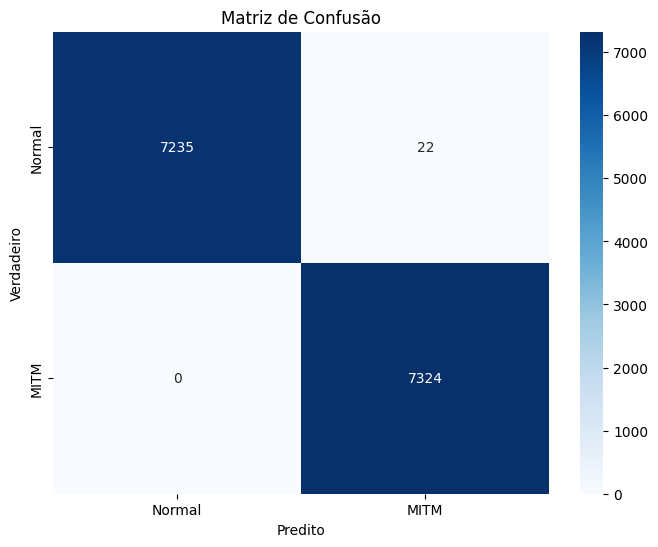

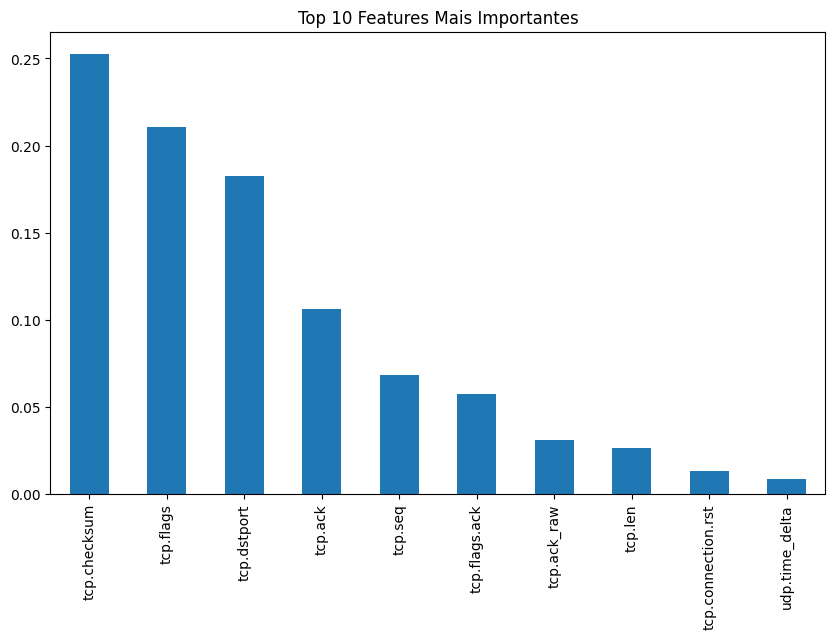

In [195]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'MITM'], yticklabels=['Normal', 'MITM'])
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# Visualizar a importância das features
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).head(10).plot(kind='bar', figsize=(10, 6))
plt.title('Top 10 Features Mais Importantes')
plt.show()

In [196]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf_model, X_smote, y_smote, cv=5, scoring='accuracy')
print("Pontuação média de validação cruzada:", cv_scores.mean())


Pontuação média de validação cruzada: 0.9983127910683376
